# ARIMA


In [2]:
# Load the saved model and make predictions on the test data    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.serialize import model_to_json, model_from_json
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
# Import the data 
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    # Convert 'date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    #df.set_index('Date', inplace=True)
    df = pd.DataFrame(df)
    return df

In [4]:
# Define the future covariates columns from your dataframe
future_covariates_columns = ['Solar_radiation (W/m2)', 'Wind_speed (m/s)', 'Temperature (°C)', 
                             'Biomass (GWh)', 'Hard_coal (GWh)', 'Hydro (GWh)', 'Lignite (GWh)', 
                             'Natural_gas (GWh)', 'Other (GWh)', 'Pumped_storage_generation (GWh)', 
                             'Solar_energy (GWh)', 'Wind_offshore (GWh)', 'Wind_onshore (GWh)', 
                             'Net_total_export_import (GWh)', 'BEV_vehicles', 'Oil_price (EUR)', 
                             'TTF_gas_price (€/MWh)', 'Nuclear_energy (GWh)']

future_covariates_columns_2 = ['Solar_radiation (W/m2)', 'Wind_speed (m/s)',
       'Temperature (°C)', 'Biomass (GWh)', 'Hard_coal (GWh)', 'Hydro (GWh)',
       'Lignite (GWh)', 'Natural_gas (GWh)', 'Other (GWh)',
       'Pumped_storage_generation (GWh)', 'Solar_energy (GWh)',
       'Wind_offshore (GWh)', 'Wind_onshore (GWh)',
       'Net_total_export_import (GWh)', 'BEV_vehicles', 'Oil_price (EUR)',
       'TTF_gas_price (€/MWh)', 'Nuclear_energy (GWh)', 'Lag_1_day',
       'Lag_2_days', 'Lag_3_days', 'Lag_4_days', 'Lag_5_days', 'Lag_6_days',
       'Lag_7_days', 'Day_of_week', 'Month', 'Rolling_mean_7']

In [9]:
# Load in the train and test data
train_df = load_and_prepare_data('../../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../../data/Final_data/test_df.csv')

# Concatenate the train and test data
df = pd.concat([train_df, test_df])
df['Date'] = pd.to_datetime(df['Date'])

df

,Date,Day_ahead_price (€/MWh),Solar_radiation (W/m2),Wind_speed (m/s),Temperature (°C),Biomass (GWh),Hard_coal (GWh),Hydro (GWh),Lignite (GWh),Natural_gas (GWh),...,Lag_1_day,Lag_2_days,Lag_3_days,Lag_4_days,Lag_5_days,Lag_6_days,Lag_7_days,Day_of_week,Month,Rolling_mean_7
0,2012-01-08,26.83,17.54,5.21,3.74,98.605,189.718,48.467,354.178,256.892,...,32.58,36.26,20.35,32.16,35.03,33.82,18.19,6,1,31.00
1,2012-01-09,47.91,13.04,4.24,3.80,98.605,344.154,49.054,382.756,282.438,...,26.83,32.58,36.26,20.35,32.16,35.03,33.82,0,1,33.02
2,2012-01-10,45.77,28.71,4.30,4.81,98.605,360.126,51.143,334.267,267.311,...,47.91,26.83,32.58,36.26,20.35,32.16,35.03,1,1,34.55
3,2012-01-11,47.83,21.58,4.08,5.14,98.605,360.330,50.693,385.000,277.343,...,45.77,47.91,26.83,32.58,36.26,20.35,32.16,2,1,36.79
4,2012-01-12,43.10,25.12,6.77,4.98,98.605,306.521,50.732,332.985,266.820,...,47.83,45.77,47.91,26.83,32.58,36.26,20.35,3,1,40.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,2024-07-24,66.61,225.04,3.47,17.54,110.007,43.469,85.857,199.246,194.291,...,79.62,88.75,58.45,59.32,86.47,90.75,76.79,2,7,75.71
755,2024-07-25,78.34,272.71,2.12,17.85,110.410,50.676,82.632,195.983,209.610,...,66.61,79.62,88.75,58.45,59.32,86.47,90.75,3,7,73.94
756,2024-07-26,93.04,172.33,2.60,19.09,110.852,42.333,79.531,205.273,205.773,...,78.34,66.61,79.62,88.75,58.45,59.32,86.47,4,7,74.88
757,2024-07-27,80.74,176.67,2.05,19.63,110.479,33.307,74.958,184.012,216.412,...,93.04,78.34,66.61,79.62,88.75,58.45,59.32,5,7,77.94


In [11]:
# Define the target column
target_column = "TTF_gas_price (€/MWh)"

In [10]:
df.columns

Index(['Date', 'Day_ahead_price (€/MWh)', 'Solar_radiation (W/m2)',
       'Wind_speed (m/s)', 'Temperature (°C)', 'Biomass (GWh)',
       'Hard_coal (GWh)', 'Hydro (GWh)', 'Lignite (GWh)', 'Natural_gas (GWh)',
       'Other (GWh)', 'Pumped_storage_generation (GWh)', 'Solar_energy (GWh)',
       'Wind_offshore (GWh)', 'Wind_onshore (GWh)',
       'Net_total_export_import (GWh)', 'BEV_vehicles', 'Oil_price (EUR)',
       'TTF_gas_price (€/MWh)', 'Nuclear_energy (GWh)', 'Lag_1_day',
       'Lag_2_days', 'Lag_3_days', 'Lag_4_days', 'Lag_5_days', 'Lag_6_days',
       'Lag_7_days', 'Day_of_week', 'Month', 'Rolling_mean_7'],
      dtype='object')

In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df[target_column])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -3.446004677008438
p-value: 0.009487047077833733


In [13]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, lags, crit_values = kpss(df[target_column])
print('KPSS Statistic:', kpss_stat)
print('p-value:', p_value)


KPSS Statistic: 2.3764625614705515
p-value: 0.01


/var/folders/8w/b_0gc01d70g6h4k62sb7ytyw0000gn/T/ipykernel_23085/2972933992.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, lags, crit_values = kpss(df[target_column])


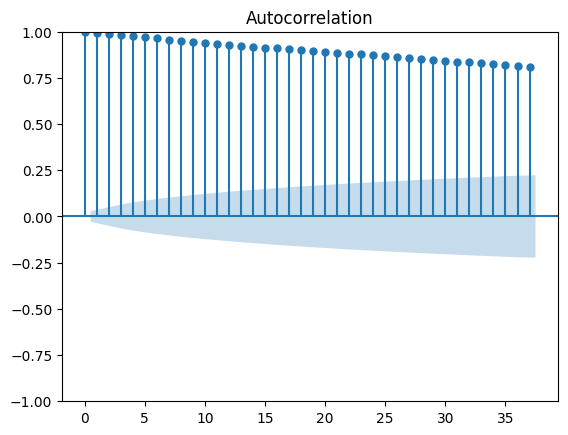

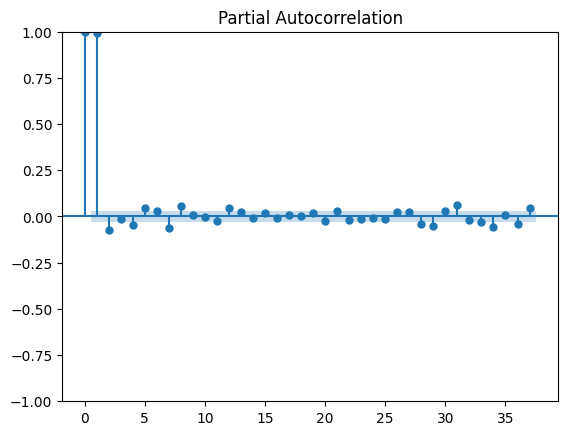

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'df' contains your time series data
plot_acf(df[target_column])
plt.show()

plot_pacf(df[target_column])
plt.show()


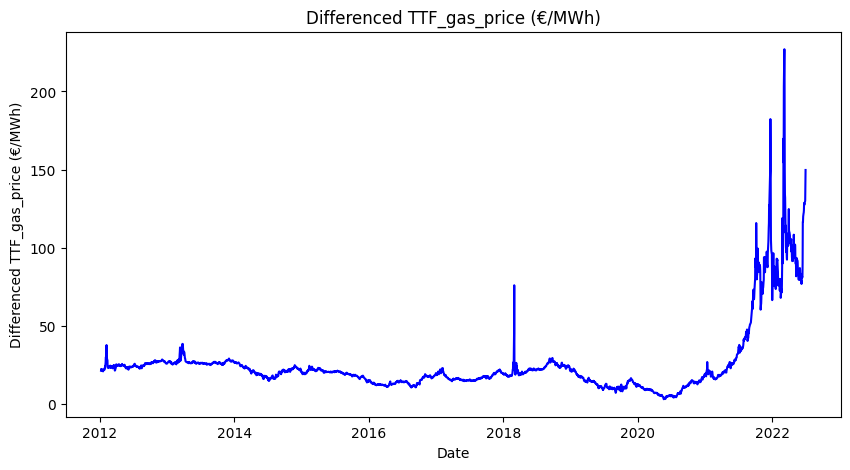

ADF Statistic: -14.870015162769088
p-value: 1.6688492422432743e-27
KPSS Statistic: 0.15537267816967634
p-value: 0.1


/var/folders/8w/b_0gc01d70g6h4k62sb7ytyw0000gn/T/ipykernel_23085/1693574238.py:32: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, crit_values = kpss(df[f'{target_column}_diff'].dropna())


In [16]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt

def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Load data
file_path = '../../../data/Final_data/train_df.csv'  # Change the path as necessary
df = load_and_prepare_data(file_path)

# Perform first-order differencing on the target variable
df[f'{target_column}_diff'] = df[target_column].diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df[target_column], color='blue')
plt.title(f'Differenced {target_column}')
plt.xlabel('Date')
plt.ylabel(f'Differenced {target_column}')
plt.show()

# Perform ADF test on differenced data
adf_result = adfuller(df[f'{target_column}_diff'].dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# Perform KPSS test on differenced data
kpss_stat, p_value, lags, crit_values = kpss(df[f'{target_column}_diff'].dropna())
print('KPSS Statistic:', kpss_stat)
print('p-value:', p_value)


## Autoarima

In [17]:
from darts.models import AutoARIMA
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
import pandas as pd
import plotly.graph_objects as go
from darts.metrics import mape, mae, rmse, mse

# Load and prepare data
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Load target and covariate data
train_df = load_and_prepare_data('../../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../../data/Final_data/test_df.csv')

df = pd.concat([train_df, test_df])

# Create target TimeSeries
series_train = TimeSeries.from_dataframe(train_df, 'Date', target_column).astype('float32')
series_test = TimeSeries.from_dataframe(test_df, 'Date', target_column).astype('float32')

# Convert covariates to TimeSeries
#covariates_train = TimeSeries.from_dataframe(train_df, 'Date', future_covariates_columns_2).astype('float32')
#covariates_test = TimeSeries.from_dataframe(test_df, 'Date', future_covariates_columns_2).astype('float32')

# Scale both target and covariates
scaler_target = Scaler()
scaler_covariates = Scaler()

series_train_scaled = scaler_target.fit_transform(series_train)
#covariates_train_scaled = scaler_covariates.fit_transform(covariates_train)
series_test_scaled = scaler_target.transform(series_test)
#covariates_test_scaled = scaler_covariates.transform(covariates_test)

# Initialize AutoARIMA model
model = AutoARIMA(
    start_p=1,
    start_q=1,
    max_p=7,
    max_q=7,
    d=None,
    seasonal=True,
    m=365,  # Adjust as necessary
    start_P=0,
    D=None,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic'
)

# Fit the model with covariates
model.fit(series_train_scaled)

# Forecast with covariates
n = len(series_test_scaled)
forecast_scaled = model.predict(n=n)

# Inverse transform the forecast
forecast = scaler_target.inverse_transform(forecast_scaled)
test_series = scaler_target.inverse_transform(series_test_scaled)

# Plot the actual vs forecasted data
fig = go.Figure()

# Add actual test data
fig.add_trace(go.Scatter(x=test_series.time_index,
                         y=test_series.values().squeeze(),
                         mode='lines', name='Actual', line=dict(color='blue')))

# Add forecasted data
fig.add_trace(go.Scatter(x=forecast.time_index,
                         y=forecast.values().squeeze(),
                         mode='lines', name='Forecast', line=dict(color='red')))

# Update layout
fig.update_layout(title='AutoARIMA Model - Forecast with Covariates',
                  xaxis_title='Date', yaxis_title='Day Ahead Price (€/MWh)',
                  legend=dict(x=1, y=1, xanchor='right', yanchor='top', bordercolor='black', borderwidth=1),
                  template='plotly_white')

# Save the plot as a PNG image
plot_path = "autoarima_forecast_plot.png"
fig.write_image(plot_path)
print(f"Forecast plot saved at: {plot_path}")

# Calculate error metrics
mape_value = mape(test_series, forecast)
mae_value = mae(test_series, forecast)
rmse_value = rmse(test_series, forecast)
mse_value = mse(test_series, forecast)

# Print error metrics
print('Error Metrics on Test Set:')
print(f'Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%')
print(f'Mean Absolute Error (MAE): {mae_value:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_value:.2f}')
print(f'Mean Squared Error (MSE): {mse_value:.2f}')

# Save error metrics to CSV
metrics_path = "autoarima_error_metrics.csv"
metrics_df = pd.DataFrame({
    "Metric": ["MAPE", "MAE", "RMSE", "MSE"],
    "Value": [mape_value, mae_value, rmse_value, mse_value]
})
metrics_df.to_csv(metrics_path, index=False)
print(f"Error metrics saved at: {metrics_path}")


Forecast plot saved at: autoarima_forecast_plot.png
Error Metrics on Test Set:
Mean Absolute Percentage Error (MAPE): 259.95%
Mean Absolute Error (MAE): 95.95
Root Mean Squared Error (RMSE): 101.17
Mean Squared Error (MSE): 10235.68
Error metrics saved at: autoarima_error_metrics.csv


11:28:49 - cmdstanpy - INFO - Chain [1] start processing
11:28:51 - cmdstanpy - INFO - Chain [1] done processing
/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



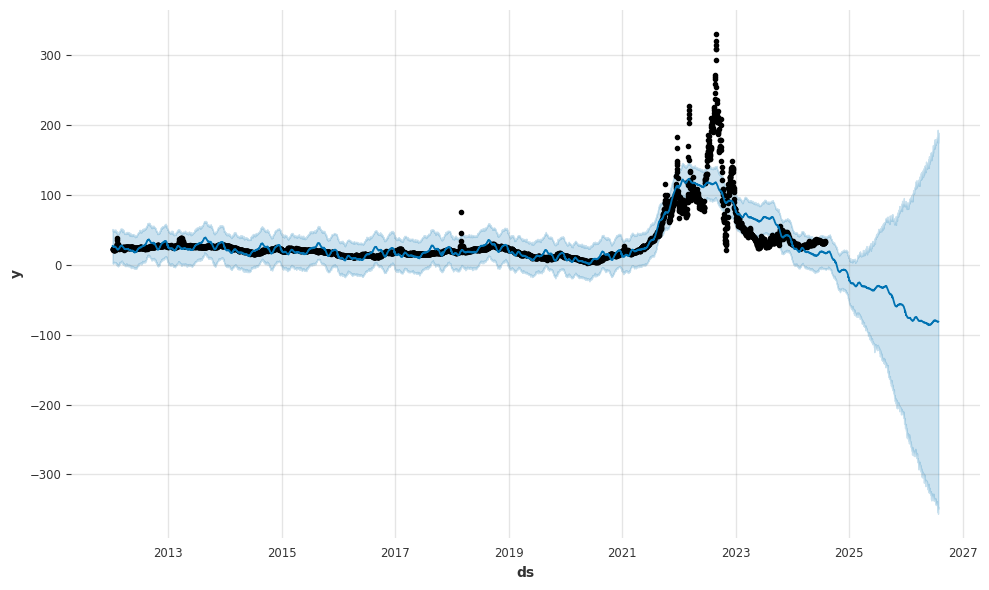

In [33]:
from prophet import Prophet
import pandas as pd
import numpy as np
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import mean_squared_error

# Load and prepare data
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Load target data
train_df = load_and_prepare_data('../../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../../data/Final_data/test_df.csv')

# Concatenate the train and test data
prophet_df = pd.concat([train_df, test_df])
prophet_df = prophet_df[['Date', target_column]].rename(columns={'Date': 'ds', target_column: 'y'})

# Initialize and fit model
m = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=True, 
    changepoint_prior_scale=0.5, 
    holidays_prior_scale=5,
    seasonality_prior_scale=5,
    scaling="absmax", 
    interval_width=0.9,
)
m.add_seasonality(name='monthly', period=30.5, fourier_order=3)
# Add holidays for Germany to the data 
m.add_country_holidays(country_name='DE')

m.fit(prophet_df)

# Create future dataframe
future = m.make_future_dataframe(periods=730)  # For two years ahead

# Forecast
forecast = m.predict(future)


# Plot forecast
fig = m.plot(forecast)


In [29]:
from prophet import Prophet
from sklearn.model_selection import ParameterGrid

param_grid = {
    'seasonality_prior_scale': [1.0, 5.0, 10.0],
    'changepoint_prior_scale': [0.05, 0.1, 0.5],
    'holidays_prior_scale': [5.0, 10.0, 20.0]
}
best_score = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    m = Prophet(
        seasonality_prior_scale=params['seasonality_prior_scale'],
        changepoint_prior_scale=params['changepoint_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale']
    )
    m.fit(prophet_df)
    forecast = m.predict(future)
    score = mean_squared_error(prophet_df['y'], forecast['yhat'][:len(prophet_df)])  # Use a metric here
    if score < best_score:
        best_score = score
        best_params = params

print("Best parameters:", best_params)


11:22:14 - cmdstanpy - INFO - Chain [1] start processing
11:22:16 - cmdstanpy - INFO - Chain [1] done processing
11:22:17 - cmdstanpy - INFO - Chain [1] start processing
11:22:18 - cmdstanpy - INFO - Chain [1] done processing
11:22:19 - cmdstanpy - INFO - Chain [1] start processing
11:22:21 - cmdstanpy - INFO - Chain [1] done processing
11:22:22 - cmdstanpy - INFO - Chain [1] start processing
11:22:23 - cmdstanpy - INFO - Chain [1] done processing
11:22:24 - cmdstanpy - INFO - Chain [1] start processing
11:22:25 - cmdstanpy - INFO - Chain [1] done processing
11:22:26 - cmdstanpy - INFO - Chain [1] start processing
11:22:28 - cmdstanpy - INFO - Chain [1] done processing
11:22:28 - cmdstanpy - INFO - Chain [1] start processing
11:22:30 - cmdstanpy - INFO - Chain [1] done processing
11:22:31 - cmdstanpy - INFO - Chain [1] start processing
11:22:32 - cmdstanpy - INFO - Chain [1] done processing
11:22:33 - cmdstanpy - INFO - Chain [1] start processing
11:22:34 - cmdstanpy - INFO - Chain [1]

Best parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5.0, 'seasonality_prior_scale': 5.0}
